# Algoritmo HOG (Histogram of Oriented Gradients)

En este notebook exploraremos el funcionamiento del algoritmo HOG, una técnica eficaz para extraer y representar características locales en imágenes mediante el cálculo de gradientes orientados en pequeñas celdas. HOG se ha consolidado como una herramienta robusta para la detección de objetos, especialmente en la identificación de peatones, ya que al combinar la descripción detallada de la estructura visual con la normalización de bloques, logra ser invariante frente a variaciones de iluminación y posición. 

Además, evaluaremos la eficiencia del algoritmo al integrarlo con un modelo SVM, que potencia su capacidad para discriminar correctamente la presencia de humanos en diferentes escenarios.

# Paso 1: Cargar y Mostra la imagen

Antes de comenzar con el algoritmo, debemos de importar las librerías necesarias y cargar la imagen con la que vamos a trabajar.

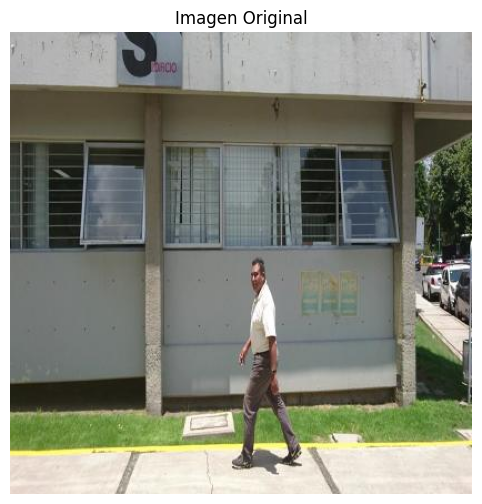

In [1]:

import cv2
import algoritmos.hog as hog
import matplotlib.pyplot as plt

ruta_imagen1 = '../src/images/test/MOV_0572_mp4-7_jpg.rf.20fa68cf07d4cf30c7534fe8d53ca117.jpg'
ruta_imagen2 = '../src/images/test/MOV_0568_mp4-1_jpg.rf.d1bccc744a8581d054d1ceb3c95f9a30.jpg'

img = cv2.imread(ruta_imagen2)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")
plt.axis("off")
plt.show()

# Paso 2: Escalar la Imagen
Escalar la imagen consiste en ajustar sus dimensiones para adecuarlas a los requerimientos del procesamiento y optimizar el rendimiento del algoritmo. Esto es especialmente útil porque:

- **Optimización computacional:** Una imagen de mayor tamaño implica más píxeles, lo que aumenta el costo computacional de los algoritmos de procesamiento, como el cálculo de gradientes y histogramas.

- **Consistencia:** Trabajar con imágenes de dimensiones uniformes facilita la comparación y el análisis de características, especialmente cuando se procesan múltiples imágenes.

- **Optimización para Detección:** Ajustar el tamaño puede mejorar la precisión en la detección de características, ya que se utiliza una escala adecuada para el algoritmo en uso.

Aunque en algunos casos se pueden procesar imágenes a su tamaño original, escalar la imagen de forma controlada permite equilibrar la calidad visual y el rendimiento del sistema.


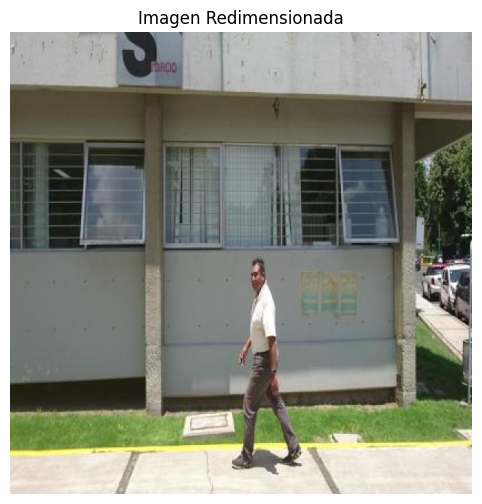

In [2]:
scale_percent = 150  # Incrementa o reduce este valor según necesites
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
img_resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

# Mostrar la imagen redimensionada
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title("Imagen Redimensionada")
plt.axis("off")
plt.show()


# Paso 3: Configuración del Detector HOG
En esta celda se definen los parámetros fundamentales para la construcción del descriptor HOG y se crea una instancia de la clase HOGDetect. Estos parámetros configuran la granularidad y el comportamiento del algoritmo, y su elección afecta directamente a la sensibilidad y precisión de la detección. A continuación, se detallan cada uno de ellos:

- **cell_siz = (8,8):** Define el tamaño de cada celda en la que se dividirá la imagen. Cada celda es una región pequeña **(8×8 píxeles)** en la que se calculará un histograma de orientaciones, capturando detalles locales de la imagen.
- **block_size = (2,2):** Especifica la cantidad de celdas que se agruparán para formar un bloque. En este caso, cada bloque contendrá **2×2** celdas. Los bloques se utilizan para normalizar los histogramas de las celdas, lo que mejora la invariancia frente a cambios de iluminación y contraste.
- **block_stride = (4,4):** Indica el desplazamiento en píxeles con el que se mueve la ventana de bloque a través de la imagen. Un stride de **(4,4)** implica un mayor solapamiento entre bloques, lo que puede aumentar la robustez del descriptor a expensas de un mayor tiempo de cómputo.
- **nbins = 9:** Número de bins en el histograma de orientaciones para cada celda. Con **9** bins, se divide uniformemente el rango de orientaciones de 0° a 180°; cada bin abarca 20°.
- **win_stride = (8,8):** Define el desplazamiento de la ventana en la etapa de detección. Un stride de **(8,8)** permite acelerar el proceso de escaneo de la imagen, evaluando menos ventanas, lo que puede ser un compromiso adecuado entre precisión y velocidad.
- **padding = (8,8):** Especifica el acolchamiento aplicado a la imagen durante la detección. Un padding de **(8,8)** ayuda a detectar objetos cerca de los bordes de la imagen sin introducir demasiado ruido.
- **scale = 1.05:** Factor de escala entre ventanas en la pirámide de escalas. Un valor de 1.05 genera suficientes escalas para capturar objetos a diferentes resoluciones, ofreciendo un equilibrio entre precisión y tiempo de procesamiento.
- **bin_width: = 20** Ancho de cada bin en el histograma, expresado en grados. Si el rango total es de 0 a 180°, con 9 bins cada bin abarca 20°.

Finalmente, se crea una instancia del detector HOG con estos parámetros, lo que permitirá realizar posteriormente el cálculo del descriptor y la detección de humanos en la imagen.

In [3]:
cell_size = (16, 16)
block_size = (2, 2)
block_stride = (4, 4)
nbins = 9
win_stride = (8, 8)  
padding = (8, 8)
scale = 1.05       
bin_width = 20

detector = hog.HOGDetect(cell_size, block_size, block_stride, nbins, win_stride, padding, scale, bin_width)


# Paso 4: Conversión a Escala de Grises
En esta etapa, se convierte la imagen redimensionada a escala de grises. Convertir la imagen a un único canal (grises) es fundamental para los procesos de análisis de gradientes y cálculo de descriptores, ya que:

- **Reducción de la complejidad:** Se elimina la información de color, simplificando la imagen a intensidades de luz. Esto permite concentrarse en las variaciones de intensidad, las cuales son esenciales para detectar bordes y estructuras.
- **Eficiencia computacional:** Trabajar con una sola canal reduce la cantidad de datos a procesar, lo que mejora la velocidad y reduce el uso de recursos.
- **Enfoque en la estructura:** Las diferencias en los niveles de gris resaltan los contornos y las formas de la imagen, facilitando el cálculo de gradientes y la posterior formación de histogramas de orientaciones.

El siguiente código realiza esta conversión utilizando el método to_grayscale definido en nuestro detector HOG y muestra el resultado:

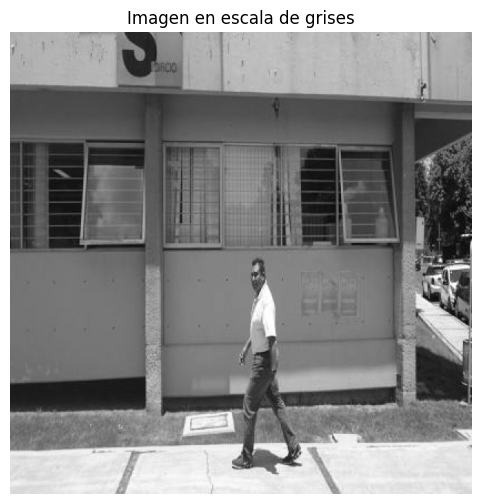

In [4]:
gray = detector.to_grayscale(img_resized)

plt.figure(figsize=(8,6))
plt.imshow(gray, cmap='gray')
plt.title("Imagen en escala de grises")
plt.axis("off")
plt.show()


# Paso 5: Cálculo y visualización de Gradientes
En esta celda se calcula la magnitud y la orientación de los gradientes de la imagen en escala de grises. Este paso es fundamental en la extracción del descriptor HOG, ya que el comportamiento de los gradientes en cada píxel captura la estructura y las transiciones de intensidad en la imagen.

- **Operador Sobel:** Se utilizan los filtros Sobel para estimar las derivadas parciales de la imagen en las direcciones horizontal **(𝐺𝑥)** y vertical **(𝐺𝑦)**. Los operadores de Sobel, **𝑆𝑥** y **𝑆𝑦**, se aplican mediante convolución con la imagen:

$$
G_x = I * S_x, \quad G_y = I * S_y
$$

donde los kernels de Sobel típicamnete son:

$$
S_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \quad
S_y = \begin{bmatrix} -1 & -2 &; -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
$$

- **Magnitud del gradiente:** La magnitud del gradiente en cada píxel se calcula como:

$$
\text{Magnitud} = \sqrt{G_x^2 + G_y^2}
$$

Esto indica la intensidad del cambio en la imagen en cada punto.

- **Orientación del gradiente:** La orientación se obtiene mediante la función arcotangente:

$$
\theta = \arctan\left(\frac{G_y}{G_x}\right)
$$

Se convierte a grados y se ajusta al rango **[0,180)** para capturar la dirección del borde o cambio en intensidad.

El siguiente código calcula los gradientes y visualiza la magnitud y la orientación del gradiente:


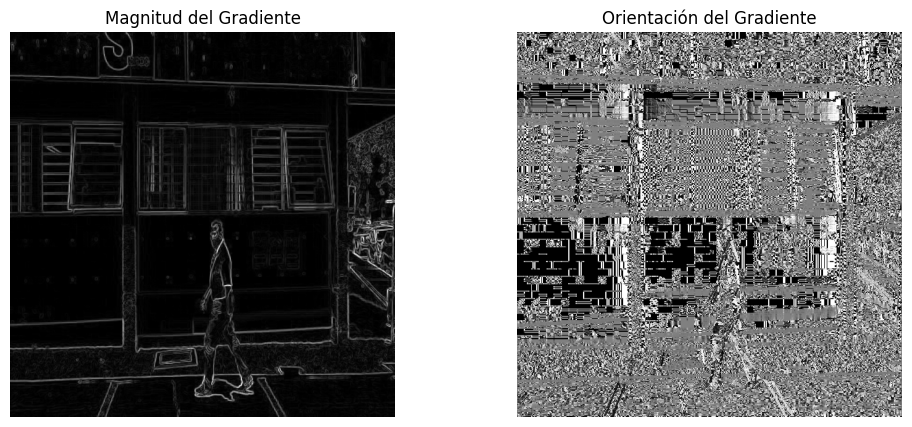

In [5]:
magnitude, angle = detector.compute_gradients(gray)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.title("Magnitud del Gradiente")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(angle, cmap='gray')
plt.title("Orientación del Gradiente")
plt.axis("off")
plt.show()


# Paso 6: Cálculo de Histograma por celda

Se divide la imagen en celdas (según el tamaño definido en cell_size) y para cada celda se calcula un histograma de orientaciones de gradiente.
Matemáticamente, la imagen se particiona en bloques pequeños de *8×8* píxeles, y para cada celda se evalúa cómo se distribuyen las orientaciones de los gradientes, acumulando la magnitud de cada píxel en el bin correspondiente del histograma.

A continuación se muestran los resultados obtenidos para la celda en la posición **(0,0)** de la imagen redimensionada:

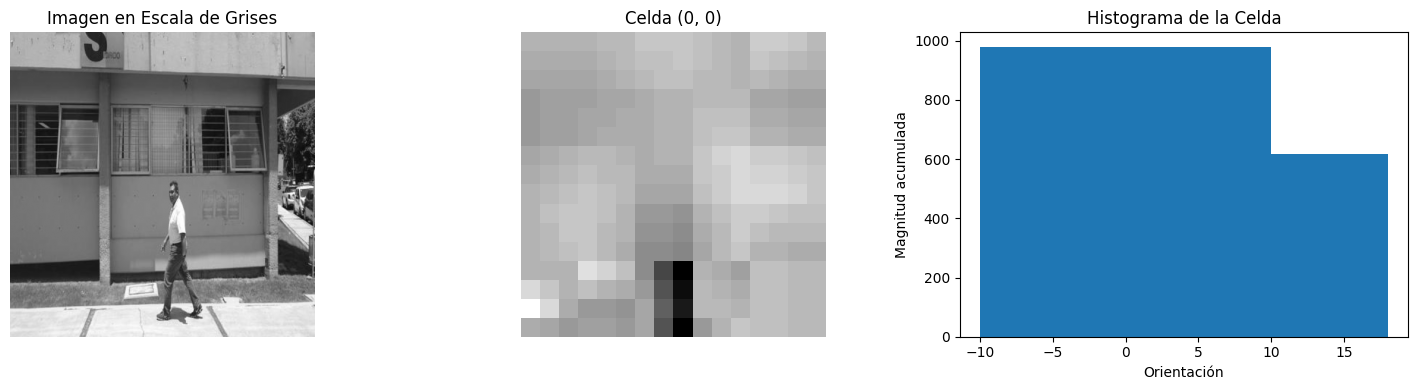

In [6]:
cell_hists = detector.compute_cell_histograms(magnitude, angle)
c_h = detector.demonstrate_cell_histogram(img_resized, cell_row=0, cell_col=0)


# Paso 7: Normalización de Bloques y Obtención del Descriptor HOG

En esta celda se lleva a cabo la última etapa del proceso manual de cálculo del descriptor HOG. El objetivo es combinar los histogramas de cada celda en bloques, normalizarlos y concatenarlos para formar el descriptor final de la imagen. Este proceso de normalización es crucial para mejorar la invariancia frente a cambios de iluminación y contraste.

- **Agrupación en bloques :** Los histogramas calculados para cada celda se agrupan en bloques **(de 2×2 celdas)**. Esto permite incorporar información del contexto local y reducir el efecto de variaciones locales en la iluminación.

- **Normalización L2 (o L2-Hys) :** Cada bloque se aplanará en un vector y se normalizará usando la norma L2 para asegurar que la magnitud total del vector sea 1 (o se limite mediante clipping en el caso de L2-Hys). Matemáticamente, si **𝑣** es el vector a normalizar, se realiza:

$$
v_{\text{norm}} = \frac{v}{\|v\|_2 + \epsilon}
$$

donde **𝜖** es una pequeña constante para evitar la división por cero.

- **Concatenación del Descriptor:** Los vectores normalizados de cada bloque se concatenan para formar un descriptor único de la imagen. Este descriptor es un vector **1D** que representa la distribución de los gradientes a lo largo de la imagen y se utiliza posteriormente para tareas de clasificación o detección.

El siguiente código realiza la normalización de los bloques y muestra propiedades importantes del descriptor resultante, como su tamaño y los primeros 10 valores:

In [7]:
hog_descriptor = detector.normalize_blocks(cell_hists)

print("Tamaño del Descriptor HOG:", hog_descriptor.shape[0]) #Cantidad total de valores (líneas) del descriptor
print("Primeros 10 valores del descriptor:", hog_descriptor[:10])

Tamaño del Descriptor HOG: 51984
Primeros 10 valores del descriptor: [0.24365625 0.10394239 0.06043645 0.08111062 0.10889497 0.11548093
 0.08421434 0.09817488 0.15398375 0.16282281]


#### Función para pintar cuadrículas

# Paso 8: Visualización del Descriptor Hog
 En esta celda se visualiza el descriptor HOG sobre la imagen redimensionada, pero limitando la visualización a un subconjunto de celdas para facilitar su interpretación. Cada celda seleccionada muestra, mediante líneas, la distribución de gradientes locales. Esto permite entender de forma intuitiva cómo se resume la información estructural de la imagen, que posteriormente se utiliza en tareas de clasificación.

---

#### ¿Cómo se dibujan líneas en cada celda? 
En cada celda seleccionada, se extrae el histograma de gradientes.
    - **Orientación del gradiente:** Cada línea se dibuja en la dirección del ángulo central del bin correspondiente. Por ejemplo, si un bin abarca de 0° a 20°, la línea se orienta hacia 10°.
    - **Magnitud del gradiente:** La longitud de cada línea es proporcional al valor en ese bin. Esto indica la prominencia de los bordes en esa dirección dentro de la celda.

---
#### ¿Cómo interpretamos ese descriptor?
El descriptor HOG en cada celda captura cómo se distribuyen las orientaciones de los gradientes localmente.

>Un bin con un valor alto significa que en esa celda existe un fuerte cambio de intensidad en la dirección representada por dicho bin.

>La visualización permite identificar patrones locales: por ejemplo, una celda donde predominan líneas en una dirección específica puede indicar la presencia de un borde o contorno característico, que es crucial para detectar la silueta de una persona.

El siguiente código realiza la visualización del descriptor HOG en 10 celdas seleccionadas, utilizando un factor de escala para ajustar la longitud de las líneas:


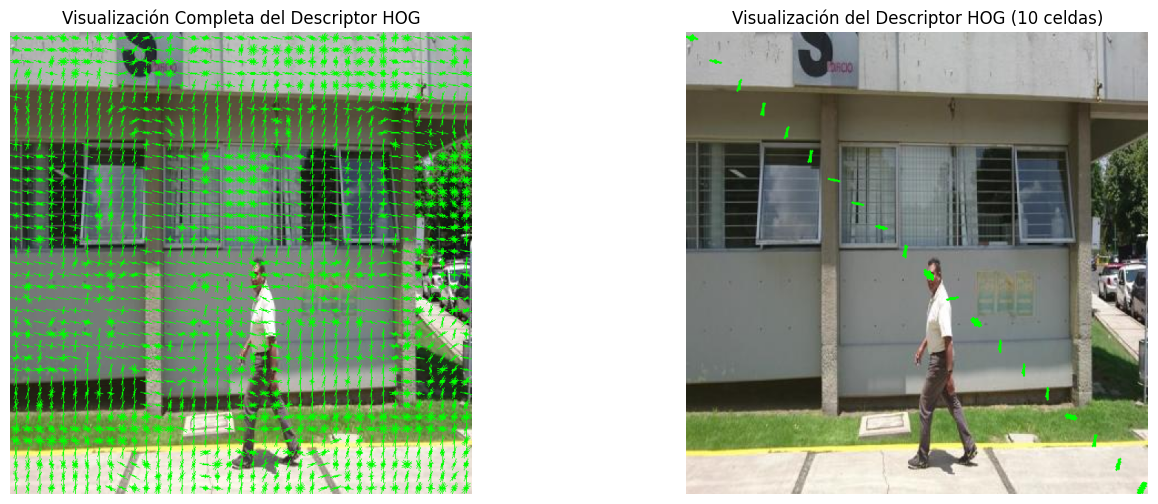

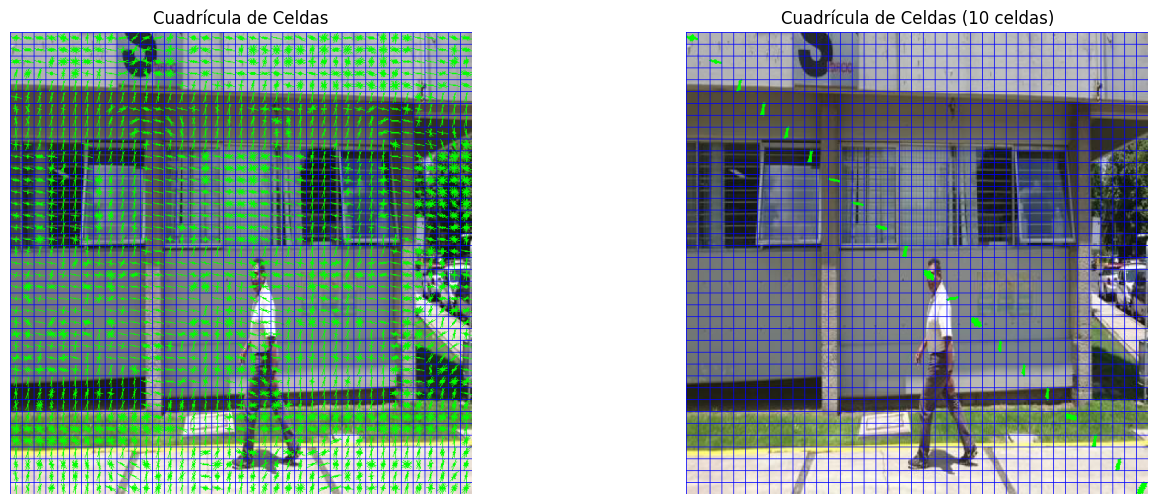

In [ ]:
hog_vis_all = detector.draw_hog_descriptor(img_resized, cell_hists, scale_factor=1.0)
hog_vis = detector.draw_hog_descriptor_subset(img_resized, cell_hists, scale_factor=1.0, max_cells=20)
hog_vis_all_grid = detector.draw_cell_grid(hog_vis_all, cell_size=(16,16))
hog_vis_grid = detector.draw_cell_grid(hog_vis, cell_size=(16,16))

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(hog_vis_all, cv2.COLOR_BGR2RGB))
plt.title("Visualización Completa del Descriptor HOG")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(hog_vis, cv2.COLOR_BGR2RGB))
plt.title("Visualización del Descriptor HOG (10 celdas)")
plt.axis("off")

plt.show()


plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(hog_vis_all_grid, cv2.COLOR_BGR2RGB))
plt.title("Cuadrícula de Celdas")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(hog_vis_grid, cv2.COLOR_BGR2RGB))
plt.title("Cuadrícula de Celdas (10 celdas)")
plt.axis("off")

plt.show()



In [15]:

filtered_rects, filtered_weights = detector.detect_humans(img_resized, threshold=0.2) 

print("Rectángulos detectados:", filtered_rects)
print("Pesos de las detecciones:", filtered_weights)


Rectángulos detectados: []
Pesos de las detecciones: []


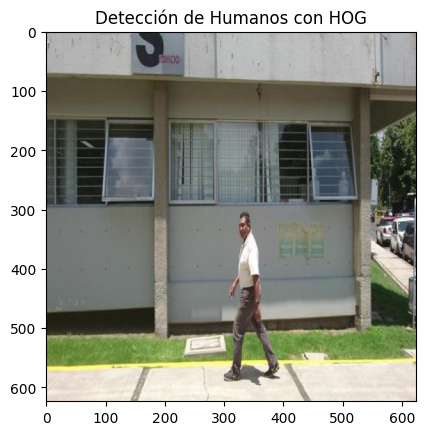

In [16]:
img_deteccion = detector.draw_detections(img_resized, filtered_rects)

detector.draw_img(img_deteccion)


In [17]:
p = cv2.HOGDescriptor_getDefaultPeopleDetector()
